In [1]:
!pip3 install yfinance seaborn sklearn statsmodels

In [2]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import yfinance as yf

data = yf.download('msft', '2016-01-01', '2022-01-30')

data.drop(['Adj Close', 'Volume'], axis=1)
data.to_csv('msft.csv')

[*********************100%***********************]  1 of 1 completed


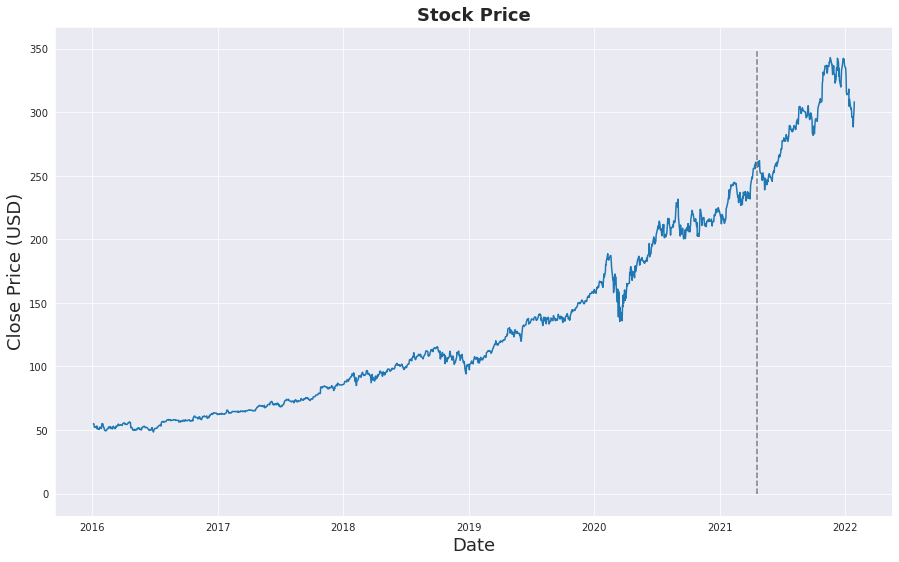

In [5]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.title("Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.vlines(datetime.date(2021,4, 20), 0, 350, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.show()

In [6]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 1530 number of days in the dataset.


In [7]:
num_training_days = int(data.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    data.shape[0]-num_training_days))

Number of training days: 1071. Number of test days: 459.


In [8]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [9]:
data = get_technical_indicators(data)

data.tail()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,,,,,,
2022-01-24,292.200012,297.109985,276.049988,296.369995,296.369995,85731500,302.139997,319.359049,316.169538,307.566331,-8.603208,15.994559,351.348167,287.369932,296.960525,295.369995
2022-01-25,291.519989,294.989990,285.170013,288.489990,288.489990,72848600,299.809998,317.159049,314.119201,304.631509,-9.487692,16.306422,349.771892,284.546206,291.313502,287.489990
2022-01-26,307.989990,308.500000,293.029999,296.709991,296.709991,90428900,297.882852,314.980953,312.829630,303.412814,-9.416816,15.691167,346.363287,283.598618,294.911162,295.709991
2022-01-27,302.660004,307.299988,297.929993,299.839996,299.839996,53481300,297.481424,313.009048,311.867435,302.863150,-9.004285,14.474439,341.957927,284.060169,298.197051,298.839996
2022-01-28,300.230011,308.480011,294.450012,308.260010,308.260010,49743700,298.185713,311.404762,311.600218,303.693436,-7.906782,12.922519,337.249800,285.559724,304.905690,307.260010


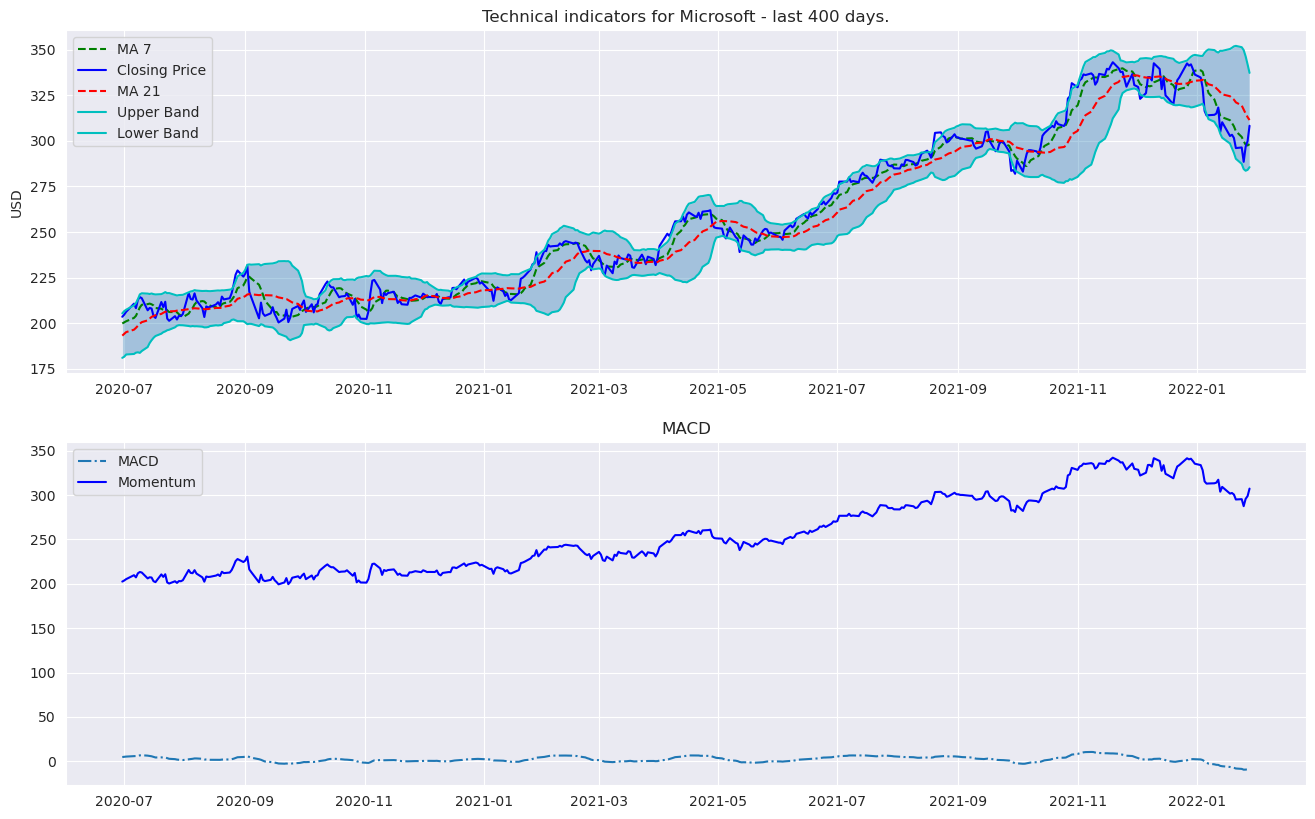

In [10]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x = list(dataset.index)
    true_lower = dataset['lower_band'].to_numpy().reshape((last_days))
    true_upper = dataset['upper_band'].to_numpy().reshape((last_days))
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset[['ma7']],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[['Close']],label='Closing Price', color='b')
    plt.plot(dataset[['ma21']],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset[['upper_band']],label='Upper Band', color='c')
    plt.plot(dataset[['lower_band']],label='Lower Band', color='c')
    plt.fill_between(x, true_lower, true_upper, alpha=0.35)
    plt.title('Technical indicators for Microsoft - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset[['MACD']],label='MACD', linestyle='-.')
    plt.plot(dataset[['momentum']],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
  
plot_technical_indicators(data, 400)

In [11]:
data_FT = data[['Close']]

close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

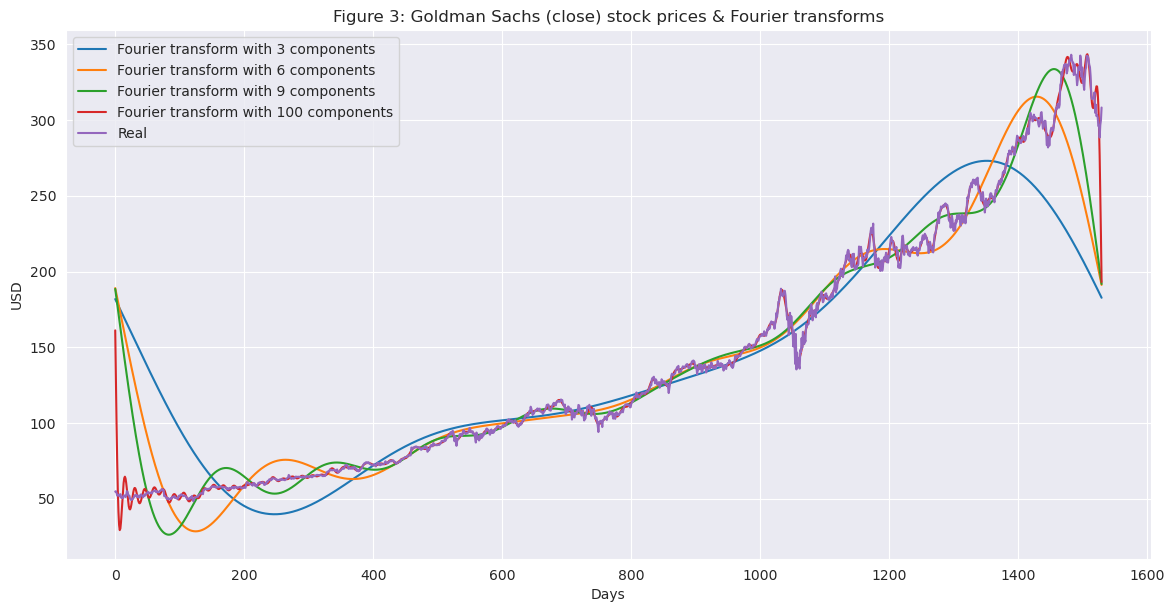

In [12]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data['Close'].to_numpy(),  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1530
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3680.983
Date:                Fri, 04 Feb 2022   AIC                           7373.967
Time:                        15:55:49   BIC                           7405.961
Sample:                             0   HQIC                          7385.874
                               - 1530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1919      0.013    -14.230      0.000      -0.218      -0.165
ar.L2          0.0593      0.014      4.129      0.000       0.031       0.087
ar.L3          0.0268      0.016      1.632      0.1

/home/luca/anaconda3/envs/stock-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luca/anaconda3/envs/stock-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/luca/anaconda3/envs/stock-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


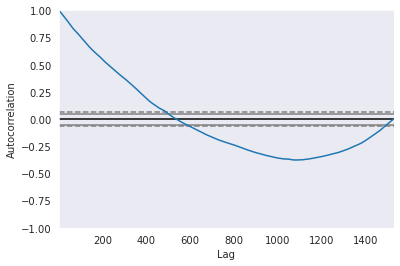

<Figure size 800x560 with 0 Axes>

In [14]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [15]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [16]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 18.786


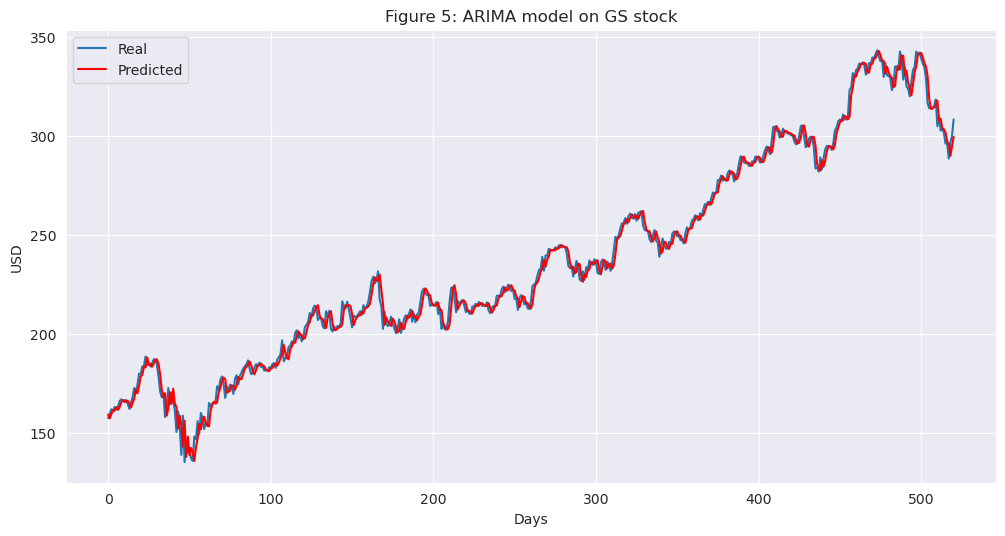

In [17]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [18]:
print('Total dataset has {} samples, and {} features.'.format(data.shape[0], \
                                                              data.shape[1]))

Total dataset has 1530 samples, and 16 features.


# Auto-Encoders

In [19]:
!pip install pytorch-lightning

In [20]:
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm

In [76]:
class StockDataset(Dataset):
    def __init__(self, data, size):
        self.dataset = []
        self.answers = []
        data = data['Close'].to_numpy(dtype=np.float32).reshape(len(data), 1)
        for i in range(len(data) - size):
            self.dataset.append(np.array(data[i : i + size]))
            self.answers.append(np.array(data[i + size]))

        n = len(self.dataset)
        self.dataset = np.array(self.dataset).reshape((1, n, size))
        self.answers = np.array(self.answers).reshape((1, n, 1))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        l = len(self.dataset[0][idx])
        return self.dataset[0][idx].reshape(1, l), self.answers[0][idx]

In [130]:
class RNNModel(pl.LightningModule):
    def __init__(self, num_embed, num_hidden, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.lstm = nn.LSTM(num_embed, num_hidden, num_layers=num_layers)
        self.decoder = nn.Linear(num_hidden, 1)
        self.num_hidden = num_hidden

    def forward(self, inputs):
        out = self.lstm(inputs)
        decoded = self.decoder(out[0])
        return decoded

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        z = self.lstm(x)
        x_hat = self.decoder(z[0])
        loss = F.mse_loss(y, x_hat)
        self.log('train_loss', loss)
        return loss


In [131]:
trainer = pl.Trainer(gpus=1)
train_dataloader = DataLoader(StockDataset(data=data, size=50), batch_size=64, shuffle=True)
model = RNNModel(50, 25, 1)
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | lstm    | LSTM   | 7.7 K 
1 | decoder | Linear | 26    
-----------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.8626533]]]
[[[5.862

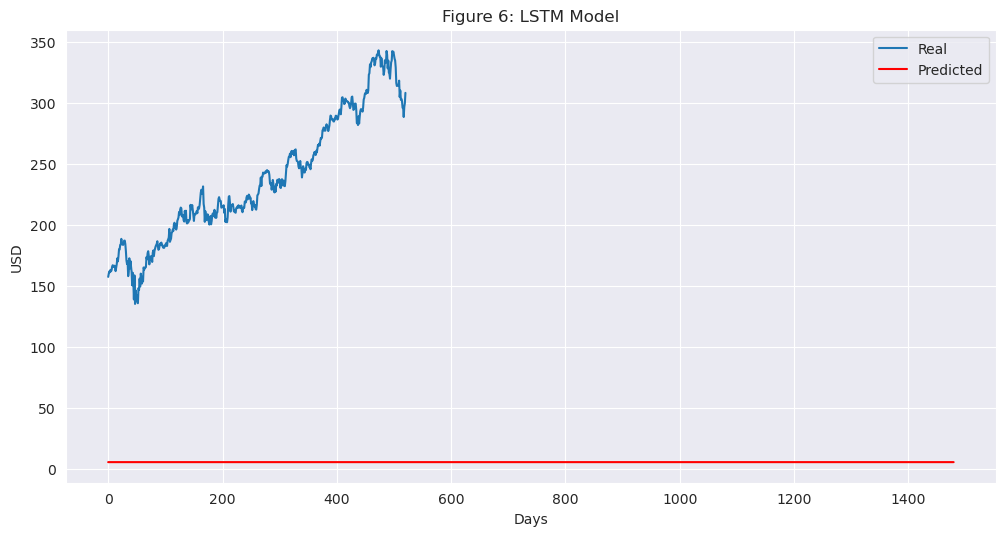

In [133]:
closes = data['Close'].to_numpy(dtype=np.float32).reshape(len(data), 1)
preds = []
for i in range(len(data) - 50):
    inf = closes[i:i+50].reshape((1, 1, 50))
    inf = torch.from_numpy(inf)
    pred = model(inf)
    print(pred.detach().numpy())
    preds.append(pred.detach().numpy()[0][0])

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(preds, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 6: LSTM Model')
plt.legend()
plt.show()